### Importing libraries and data

In [2]:
# !pip install lightgbm
# !pip install seaborn --upgrade

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

import re
from scipy import stats
from tqdm import tqdm
import glob
import time

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from utils import (clean_text, calculate_churn_risk_score, map_target_data, preprocess_data, calculate_churn_risk_score, 
    select_train_data, load_all_feature_names, scale_test_data, load_models, 
    load_model_params, tune_model, train_models, evaluate_model)

#### Functions

In [5]:
def load_train_feature_sets():
    
    train_feature_sets = {
        '[X_tr_imb, y_tr_imb]' : [X_tr_imb, y_tr_imb], 
        '[X_tr_imb_std, y_tr_imb]' : [X_tr_imb_std, y_tr_imb],
        '[X_tr_imb_minmax, y_tr_imb]' : [X_tr_imb_minmax, y_tr_imb],
        '[X_tr_smote, y_tr_smote]' : [X_tr_smote, y_tr_smote],
        '[X_tr_smote_std, y_tr_smote]' : [X_tr_smote_std, y_tr_smote],
        '[X_tr_smote_minmax, y_tr_smote]' : [X_tr_smote_minmax, y_tr_smote],
        '[X_tr_adasyn, y_tr_adasyn]' : [X_tr_adasyn, y_tr_adasyn],
        '[X_tr_adasyn_std, y_tr_adasyn]' : [X_tr_adasyn_std, y_tr_adasyn],
        '[X_tr_adasyn_minmax, y_tr_adasyn]' : [X_tr_adasyn_minmax, y_tr_adasyn]
    }

    return train_feature_sets


def load_test_feature_sets():
    
    test_feature_sets = {
        '[X_te_imb, y_te_imb]' : [X_te_imb, y_te_imb],
        '[X_te_imb_std, y_te_imb]' : [X_te_imb_std, y_te_imb],
        '[X_te_imb_minmax, y_te_imb]' : [X_te_imb_minmax, y_te_imb],
        '[X_te_smote_std, y_te_smote]' : [X_te_smote_std, y_te_smote],
        '[X_te_smote_minmax, y_te_smote]' : [X_te_smote_minmax, y_te_smote],
        '[X_te_adasyn_std, y_te_adasyn]' : [X_te_adasyn_std, y_te_adasyn],
        '[X_te_adasyn_minmax, y_te_adasyn]' :  [X_te_adasyn_minmax, y_te_adasyn]   
    }

    return test_feature_sets

#### Feature sets for train data

There are 9 different feature sets prepared at preprocessing step.

Combination of imbalanced, smote balanced and adasyn balanced with that of unscaled, standard scaled and min-max scaled

In [8]:
# allowed_samples = ['None', 'smote', 'adasyn']
# allowed_scales = ['None', 'standard', 'minmax']

X_tr_imb, y_tr_imb = select_train_data('None', 'None')
X_tr_imb_std, y_tr_imb = select_train_data('None', 'standard')
X_tr_imb_minmax, y_tr_imb = select_train_data('None', 'minmax')

X_tr_smote, y_tr_smote = select_train_data('smote', 'None')
X_tr_smote_std, y_tr_smote = select_train_data('smote', 'standard')
X_tr_smote_minmax, y_tr_smote = select_train_data('smote', 'minmax')

X_tr_adasyn, y_tr_adasyn = select_train_data('adasyn', 'None')
X_tr_adasyn_std, y_tr_adasyn = select_train_data('adasyn', 'standard')
X_tr_adasyn_minmax, y_tr_adasyn = select_train_data('adasyn', 'minmax')

In [9]:
# train feature sets

train_feature_sets = load_train_feature_sets()
len(train_feature_sets)

9

#### Feature sets for test data

In [11]:
with open(r'.\data_for_model\test\test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

X_test.shape, y_test.shape

((1407, 19), (1407,))

In [12]:
y_te_imb = map_target_data(y_test)
X_te_imb = preprocess_data(X_test)
X_te_imb.head(2)

,tenure,MonthlyCharges,TotalCharges,Charges_to_tenure_ratio,Charges_to_tenure_ratio_transformed,tenure_transformed,MonthlyCharges_transformed,TotalCharges_transformed,New_Churn_Risk_Score,gender,...,PaymentMethod_bank_transfer,PaymentMethod_credit_card,PaymentMethod_electronic_check,PaymentMethod_mailed_check,New_tenure_Year_0_1_Year,New_tenure_Year_1_2_Year,New_tenure_Year_2_3_Year,New_tenure_Year_3_4_Year,New_tenure_Year_4_5_Year,New_tenure_Year_5_6_Year
0,59,75.95,4542.35,1.287288,-0.671003,0.783330,0.179102,0.852786,2,0,...,0,1,0,0,0,0,0,0,1,0
1,7,78.55,522.95,11.221429,0.941908,-0.798769,0.215679,-0.561638,7,0,...,1,0,0,0,1,0,0,0,0,0


In [13]:
# allowed_samples = ['smote', 'adasyn']
# allowed_scales = ['standard', 'minmax']

X_te_imb_std, y_te_imb = scale_test_data('None', 'standard', data=[X_te_imb, y_te_imb])
X_te_imb_minmax, y_te_imb =  scale_test_data('None', 'minmax', data=[X_te_imb, y_te_imb])

X_te_smote_std, y_te_smote = scale_test_data('smote', 'standard', data=[X_te_imb, y_te_imb])
X_te_smote_minmax, y_te_smote = scale_test_data('smote', 'minmax', data=[X_te_imb, y_te_imb])

X_te_adasyn_std, y_te_adasyn = scale_test_data('adasyn', 'standard', data=[X_te_imb, y_te_imb])
X_te_adasyn_minmax, y_te_adasyn = scale_test_data('adasyn', 'minmax', data=[X_te_imb, y_te_imb])

In [14]:
# test feature sets

test_feature_sets = load_test_feature_sets()

len(test_feature_sets)

7

#### Training Models

In [16]:
%%time
results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_imb_std, y_tr_imb]', '[X_te_imb_std, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_imb_minmax, y_tr_imb]', '[X_te_imb_minmax, y_te_imb]', train_feature_sets, test_feature_sets)

results += train_models('[X_tr_smote, y_tr_smote]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_te_smote]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_smote_minmax, y_tr_smote]', '[X_te_smote_minmax, y_te_smote]', train_feature_sets, test_feature_sets)

results += train_models('[X_tr_adasyn, y_tr_adasyn]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_adasyn_std, y_tr_adasyn]', '[X_te_adasyn_std, y_te_adasyn]', train_feature_sets, test_feature_sets)
results += train_models('[X_tr_adasyn_minmax, y_tr_adasyn]', '[X_te_adasyn_minmax, y_te_adasyn]', train_feature_sets, test_feature_sets)

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:03<00:00,  1.33it/s]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:04<00:00,  1.25it/s]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1776
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:04<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:12<00:02,  2.72s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.51s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.49s/it]

[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:13<00:02,  2.46s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:06<00:01,  1.45s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:06<00:01,  1.42s/it]

[LightGBM] [Info] Number of positive: 4178, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8308, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502889 -> initscore=0.011555
[LightGBM] [Info] Start training from score 0.011555


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.24s/it]

CPU times: total: 1min 4s
Wall time: 1min 11s


In [17]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1', 'Model'], ascending=[False, True])

,Model,train_data,test_data,train_f1,test_f1
0,Logistic Regression,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.7994,0.7991
48,Logistic Regression,"[X_tr_adasyn_minmax, y_tr_adasyn]","[X_te_adasyn_minmax, y_te_adasyn]",0.8616,0.7985
12,Logistic Regression,"[X_tr_imb_minmax, y_tr_imb]","[X_te_imb_minmax, y_te_imb]",0.8035,0.7970
30,Logistic Regression,"[X_tr_smote_minmax, y_tr_smote]","[X_te_smote_minmax, y_te_smote]",0.8607,0.7968
24,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_te_smote]",0.8606,0.7959
42,Logistic Regression,"[X_tr_adasyn_std, y_tr_adasyn]","[X_te_adasyn_std, y_te_adasyn]",0.8620,0.7947
6,Logistic Regression,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8034,0.7930
8,SVC,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8087,0.7853
44,SVC,"[X_tr_adasyn_std, y_tr_adasyn]","[X_te_adasyn_std, y_te_adasyn]",0.8698,0.7827
29,LightGBM,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_te_smote]",0.9161,0.7824


**Observation:**

1. Logistic Regression looks promising
2. SVC, randomforest and lightgbm are other algos to try on certain feature sets

#### Tuning top models

In [29]:
%%time

results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_te_imb, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression()})
results += train_models('[X_tr_imb_std, y_tr_imb]', '[X_te_imb_std, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression(),
                                                                                                  'SVC': SVC(),
                                                                                                  'Random Forest': RandomForestClassifier()})
results += train_models('[X_tr_imb_minmax, y_tr_imb]', '[X_te_imb_minmax, y_te_imb]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression()})

results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_te_smote]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression(),
                                                                                                           'LightGBM': LGBMClassifier()})
results += train_models('[X_tr_smote_minmax, y_tr_smote]', '[X_te_smote_minmax, y_te_smote]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression(),
                                                                                                                'SVC': SVC(),
                                                                                                                'LightGBM': LGBMClassifier()})

results += train_models('[X_tr_adasyn_std, y_tr_adasyn]', '[X_te_adasyn_std, y_te_adasyn]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression(),
                                                                                                                'SVC': SVC()})
results += train_models('[X_tr_adasyn_minmax, y_tr_adasyn]', '[X_te_adasyn_minmax, y_te_adasyn]', train_feature_sets, test_feature_sets, tune=True, models={'Logistic Regression': LogisticRegression(),
                                                                                                                'SVC': SVC()})

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.32it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:17<00:10, 10.26s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.49s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] 

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.93s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:56<00:33, 33.17s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 53
[LightGBM] [Info] 

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.97s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:02<00:02,  2.04s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:53<00:00, 26.55s/it]

CPU times: total: 33.2 s
Wall time: 7min 17s


In [30]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1', 'Model'], ascending=[False, True])

,Model,train_data,test_data,train_f1,test_f1
12,Logistic Regression,"[X_tr_adasyn_minmax, y_tr_adasyn]","[X_te_adasyn_minmax, y_te_adasyn]",0.8616,0.7985
7,Logistic Regression,"[X_tr_smote_minmax, y_tr_smote]","[X_te_smote_minmax, y_te_smote]",0.8607,0.7968
4,Logistic Regression,"[X_tr_imb_minmax, y_tr_imb]","[X_te_imb_minmax, y_te_imb]",0.8040,0.7952
10,Logistic Regression,"[X_tr_adasyn_std, y_tr_adasyn]","[X_te_adasyn_std, y_te_adasyn]",0.8640,0.7947
5,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_te_smote]",0.8638,0.7940
0,Logistic Regression,"[X_tr_imb, y_tr_imb]","[X_te_imb, y_te_imb]",0.7988,0.7933
1,Logistic Regression,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8043,0.7926
2,SVC,"[X_tr_imb_std, y_tr_imb]","[X_te_imb_std, y_te_imb]",0.8107,0.7821
13,SVC,"[X_tr_adasyn_minmax, y_tr_adasyn]","[X_te_adasyn_minmax, y_te_adasyn]",0.8791,0.7813
9,LightGBM,"[X_tr_smote_minmax, y_tr_smote]","[X_te_smote_minmax, y_te_smote]",0.9149,0.7812


**Observation:**

  
    1. Logistic regression works best with this data
    2. Logistic regression fit on upsampled data and other models like RandomForest, some SVC and Lightgbm models slightly overfit

Below is the illustration for one overfitting model

In [41]:
models = load_models()
model_params = load_model_params()

model = models['Logistic Regression']
param_grid = model_params['Logistic Regression']

In [43]:
best_model = tune_model('grid', model, param_grid, X_tr_adasyn_minmax, y_tr_adasyn, scoring=['accuracy','f1_weighted', 'roc_auc'], n_iter=10, cv=5, random_state=42)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


weighted f1_score- train_f1: 0.8616 test_f1: 0.7985 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4130
           1       0.87      0.85      0.86      4178

    accuracy                           0.86      8308
   macro avg       0.86      0.86      0.86      8308
weighted avg       0.86      0.86      0.86      8308
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1033
           1       0.62      0.63      0.62       374

    accuracy                           0.80      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407





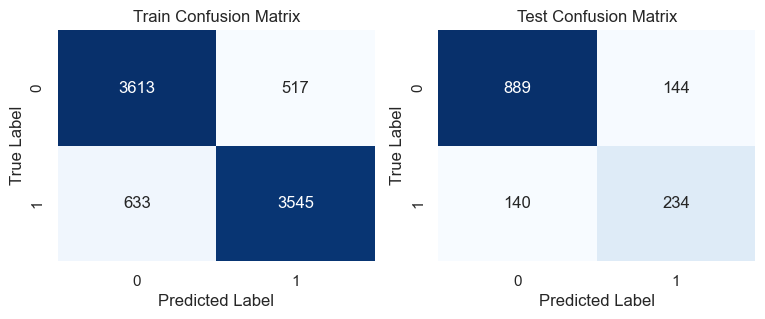

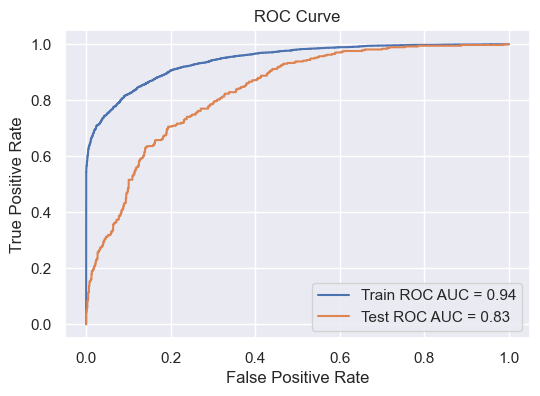

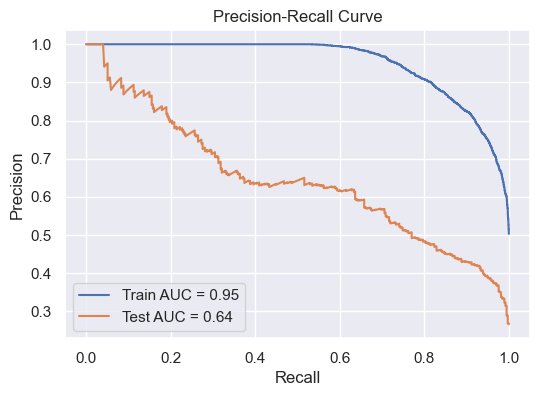

In [44]:
evaluate_model(best_model, X_tr_adasyn_minmax, y_tr_adasyn, X_te_adasyn_minmax, y_te_adasyn)

**Observation:** 

        We can see that test f1_score is much lower compared to train f1_score. 
        Similarly, area under ROC_AUC & Precision-recall curves is much lower for test data compared to train data

#### Final Model and feature set selected

In [47]:
models = load_models()
model_params = load_model_params()

In [49]:
model = models['Logistic Regression']
param_grid = model_params['Logistic Regression']

In [51]:
best_model = tune_model('grid', model, param_grid, X_tr_imb_minmax, y_tr_imb, scoring=['accuracy','f1_weighted', 'roc_auc'], n_iter=10, cv=5, random_state=42)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [65]:
with open(r'.\final_model\train_data.pkl', 'wb') as f:
    pickle.dump([X_tr_imb_minmax, y_tr_imb], f)

with open(r'.\final_model\test_data.pkl', 'wb') as f:
    pickle.dump([X_te_imb_minmax, y_te_imb], f)

with open(r'.\final_model\final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

weighted f1_score- train_f1: 0.804 test_f1: 0.7952 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      4130
           1       0.68      0.55      0.61      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.55      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407





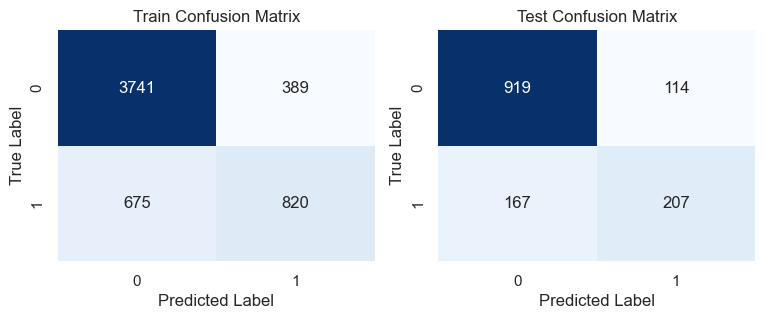

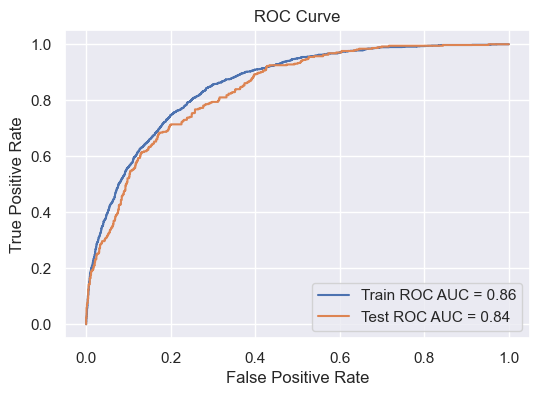

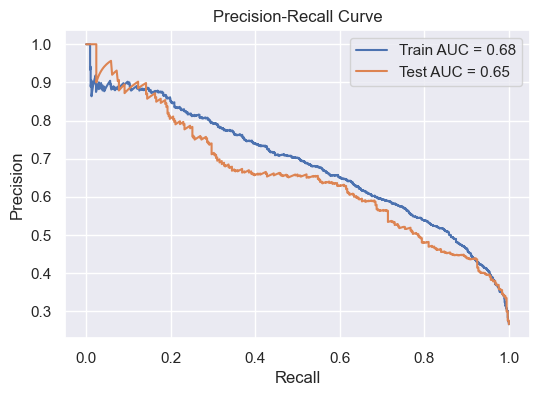

In [67]:
evaluate_model(best_model, X_tr_imb_minmax, y_tr_imb, X_te_imb_minmax, y_te_imb)

**Observation:** Model is fit appropriately

#### Feature Importance

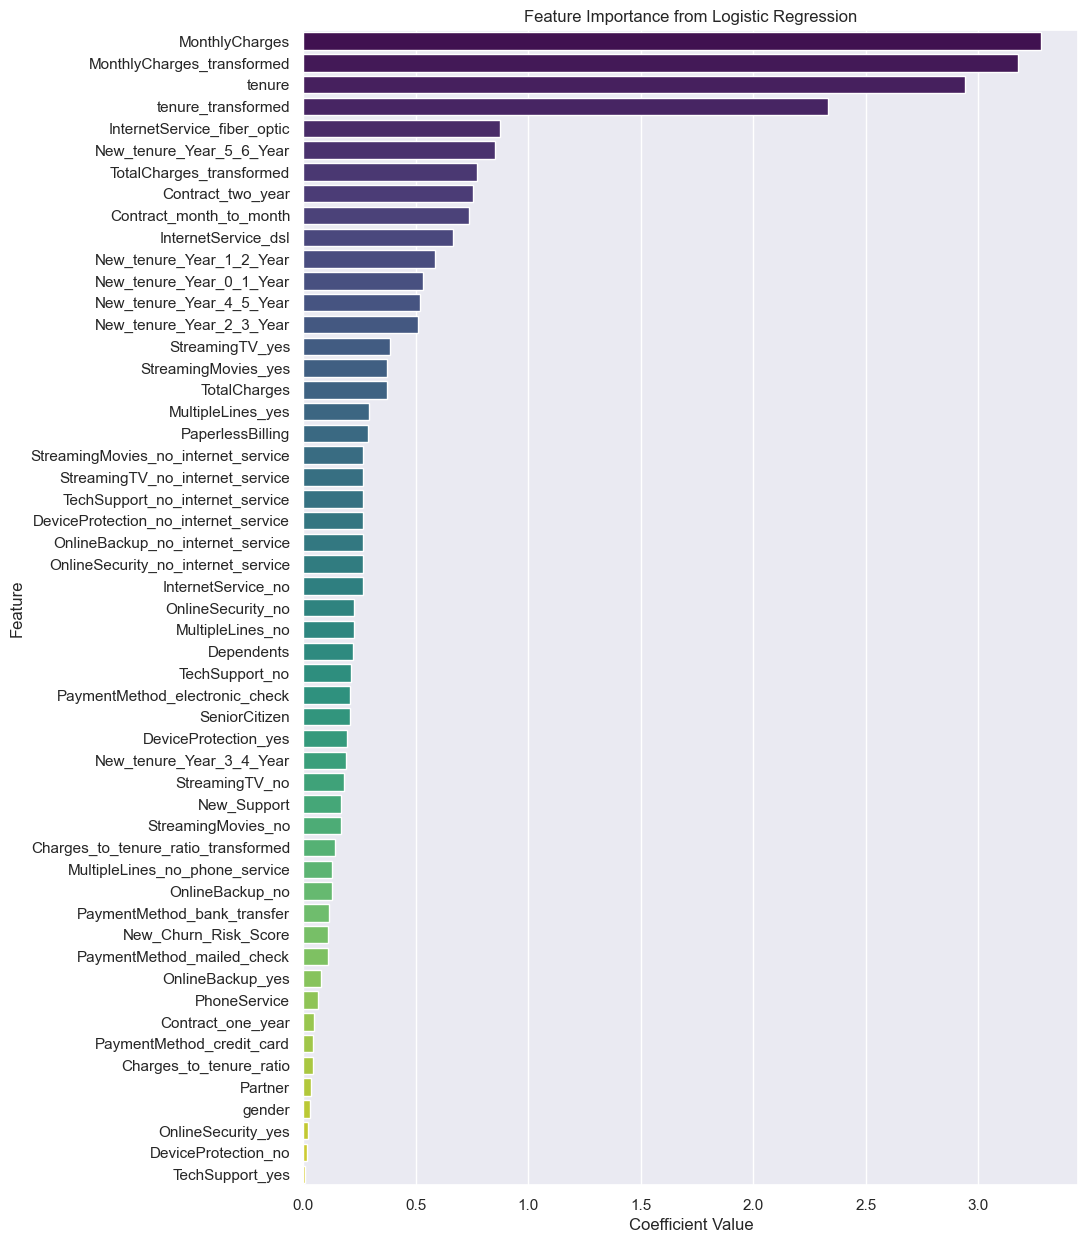

In [71]:
# Extract coefficients and feature names
coefficients = best_model.coef_[0]  # For binary classification, use [0]; for multi-class, you might need to adjust
feature_names = X_tr_imb_minmax.columns

# Create a DataFrame for better visualization
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute value of coefficient
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importance, y='Feature', x='Absolute Coefficient', palette='viridis')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.show()

#### Fine Tune

Text(0.5, 1.0, 'Absolute Correlation Matrix')

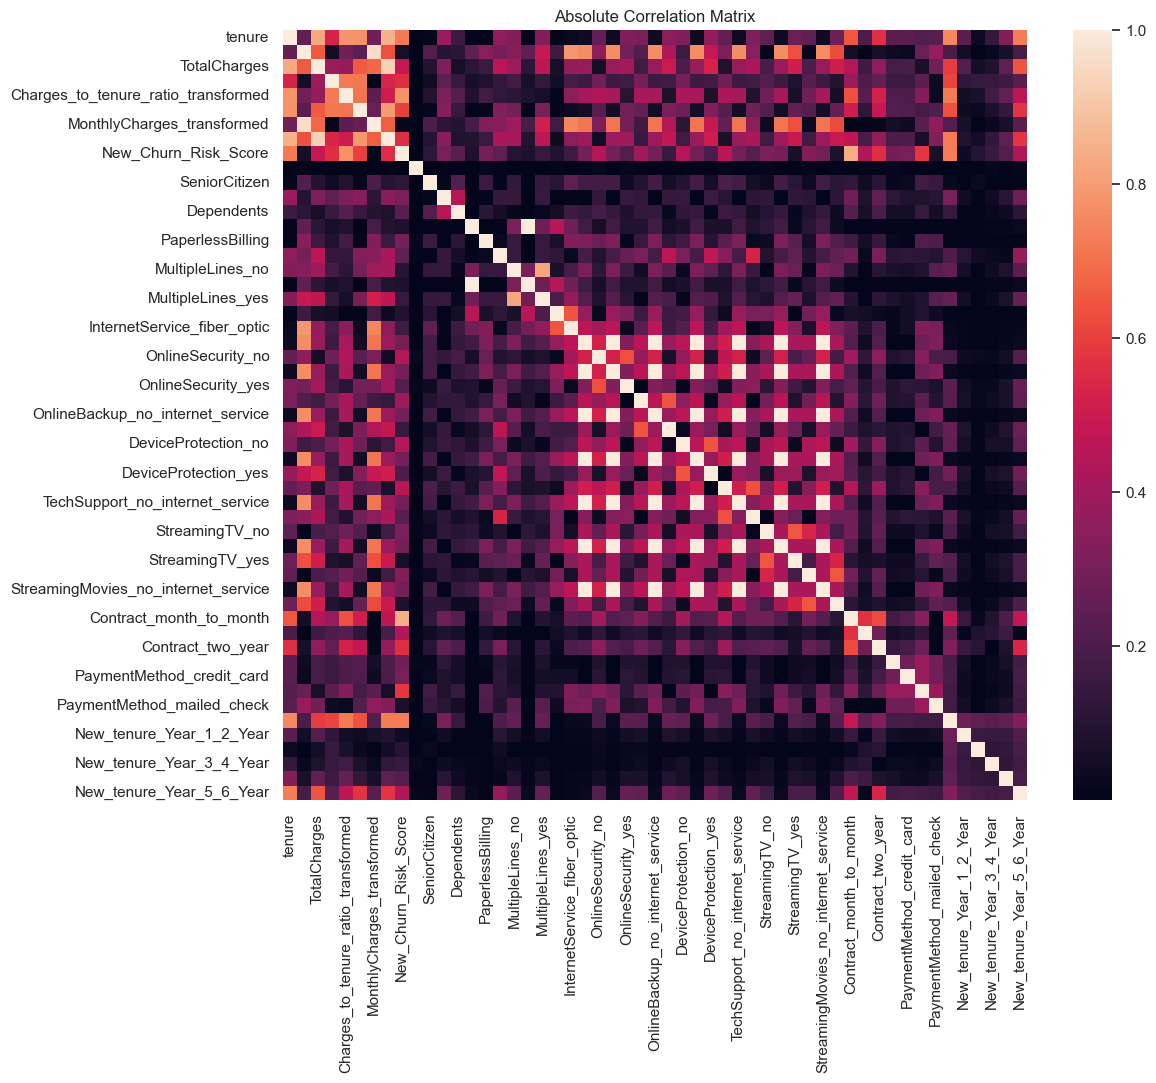

In [73]:
corr_matrix = X_tr_imb_minmax.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.abs())
plt.title('Absolute Correlation Matrix')

In [74]:
# Set a threshold for high correlation
threshold = 0.96
to_remove = set()

# Identify features to remove
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_remove.add(colname)

print("Features to remove:", to_remove)

Features to remove: {'TechSupport_no_internet_service', 'StreamingTV_no_internet_service', 'OnlineBackup_no_internet_service', 'OnlineSecurity_no_internet_service', 'StreamingMovies_no_internet_service', 'MultipleLines_no_phone_service', 'DeviceProtection_no_internet_service'}


In [75]:
# Remove the identified features
X_tr_imb_minmax_reduced = X_tr_imb_minmax.drop(columns=to_remove)
X_te_imb_minmax_reduced = X_te_imb_minmax.drop(columns=to_remove)

# print("Original feature set:", X_tr_imb_minmax.columns)
# print("Reduced feature set:", X_tr_imb_minmax_reduced.columns)

In [76]:
best_model = tune_model('grid', model, param_grid, X_tr_imb_minmax_reduced, y_tr_imb, scoring=['accuracy','f1_weighted', 'roc_auc'], n_iter=10, cv=5, random_state=42)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [77]:
with open(r'.\final_model\train_data_reduced_features.pkl', 'wb') as f:
    pickle.dump([X_tr_imb_minmax_reduced, y_tr_imb], f)

with open(r'.\final_model\test_data_reduced_features.pkl', 'wb') as f:
    pickle.dump([X_te_imb_minmax_reduced, y_te_imb], f)

with open(r'.\final_model\final_model_for_reduced_features.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

weighted f1_score- train_f1: 0.8008 test_f1: 0.7972 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      4130
           1       0.68      0.53      0.60      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.72      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1033
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407





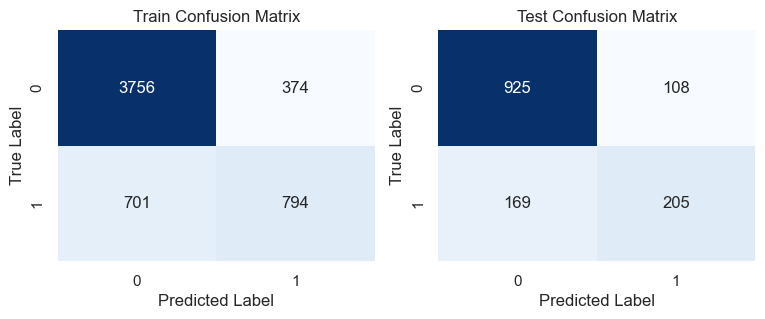

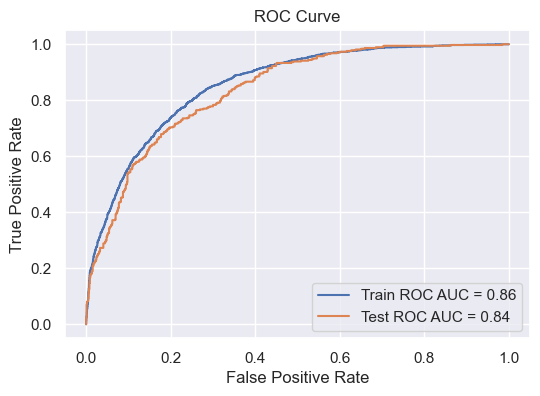

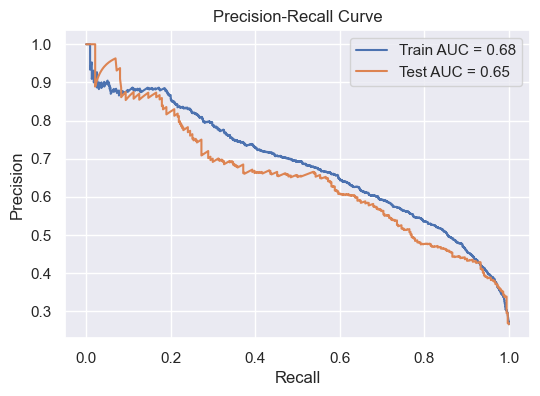

In [78]:
evaluate_model(best_model, X_tr_imb_minmax_reduced, y_tr_imb, X_te_imb_minmax_reduced, y_te_imb)

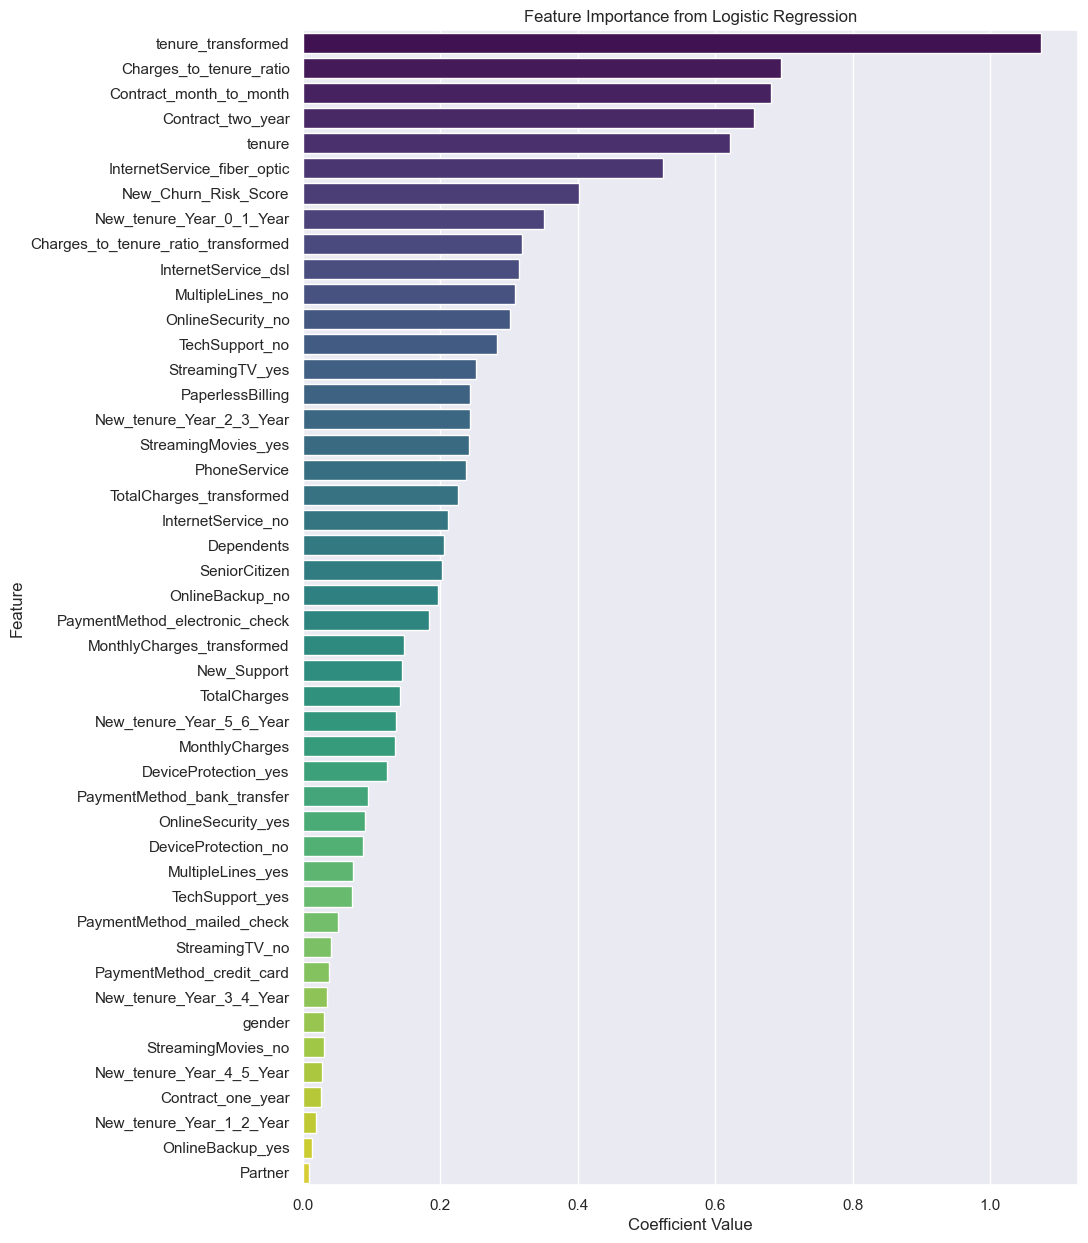

In [80]:
# Extract coefficients and feature names
coefficients = best_model.coef_[0]  # For binary classification, use [0]; for multi-class, you might need to adjust
feature_names = X_tr_imb_minmax_reduced.columns

# Create a DataFrame for better visualization
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by absolute value of coefficient
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 15))
sns.barplot(data=feature_importance, y='Feature', x='Absolute Coefficient', palette='viridis')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.show()

In [81]:
feature_importance['%age_explanability'] = round(feature_importance['Absolute Coefficient'] / feature_importance['Absolute Coefficient'].sum() * 100,2)

In [82]:
print("Top 10 features:")
feature_importance[:10]

Top 10 features:


,Feature,Coefficient,Absolute Coefficient,%age_explanability
5,tenure_transformed,-1.074323,1.074323,10.20
3,Charges_to_tenure_ratio,0.695855,0.695855,6.61
33,Contract_month_to_month,0.681686,0.681686,6.47
35,Contract_two_year,-0.656275,0.656275,6.23
0,tenure,-0.621502,0.621502,5.90
19,InternetService_fiber_optic,0.524641,0.524641,4.98
8,New_Churn_Risk_Score,0.401544,0.401544,3.81
40,New_tenure_Year_0_1_Year,0.350271,0.350271,3.33
4,Charges_to_tenure_ratio_transformed,0.318926,0.318926,3.03
18,InternetService_dsl,-0.313854,0.313854,2.98
